<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np
from bayes import *
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import statsmodels.stats.api as sms
from scipy.stats import norm, sem
import pylab as plt

In [2]:
datos=pd.read_csv('data/cookie_cats.csv')

In [74]:
# datos metodo bayes
#retention 1
total_c, control= 44700 , 20034
total, prueba= 45489 , 20119

cr_control= control/total_c
cr_test=prueba/total
#retention 7

total_c_2, control_2= 44700 , 8502
total_2, prueba_2= 45489 , 8279

cr_control_2= control/total_c_2
cr_test_2=prueba_2/total_2

In [4]:
# transformacion


In [5]:
# muestreo


In [75]:
# testeo para retention_1
a_C, b_C = 1+control, 1+total_c-control

a_T, b_T = 1+prueba, 1+total-prueba

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

beta_control.mean(), beta_test.mean()

salto = (beta_test.mean() - beta_control.mean())/beta_control.mean()

prob=1-calc_prob(beta_control, beta_test)  # esta funcion es la clave


El test ### la tasa de conversion en un -1.32%, con una probabilidad del 3.72%


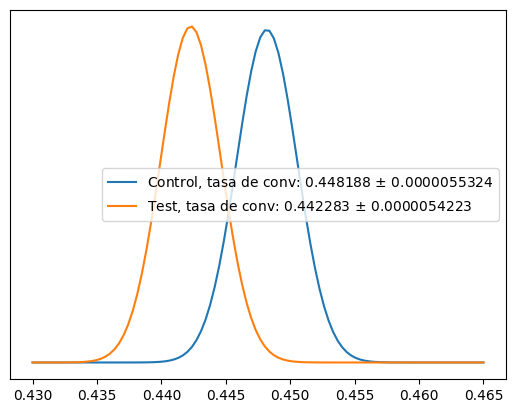

In [77]:
print('''El test ### la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100))
plot([beta_control, beta_test], ['Control', 'Test'], linf=0.43, lsup = 0.465)

In [8]:
# testeo para retention_7
a_C, b_C = 1+control_2, 1+total_c_2-control_2

a_T, b_T = 1+prueba_2, 1+total_2-prueba_2

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

beta_control.mean(), beta_test.mean()

salto = (beta_test.mean() - beta_control.mean())/beta_control.mean()

prob=1-calc_prob(beta_control, beta_test)  # esta funcion es la clave


El test ### la tasa de conversion en un -4.31%, con una probabilidad del 0.08%


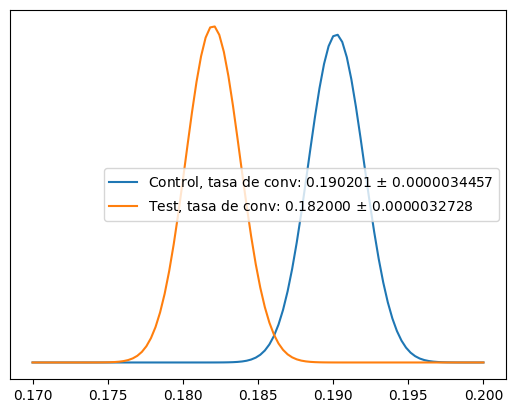

In [9]:
print('''El test ### la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100))
plot([beta_control, beta_test], ['Control', 'Test'], linf=0.17, lsup = 0.2)

In [10]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.
# que el tratamiento en ambos caso es inferior al grupo de control por lo que de una manera significatica, estan perdiendo jugadores, por un lado es cierto que se pierden menos jugadores en la retencion ded 1 debido a que las graficas estan cercanas, y eñ punto de corte es mayor, mientras que ne la 
#retencion 7 se observa mayor decadencia de jugadores y persistencia

In [61]:
control=datos[datos.version=='gate_30']
trat=datos[datos.version=='gate_40']
#tasas de conversion
conversion_control = control['retention_7'].mean()
conversion_tratamiento = trat['retention_7'].mean()
conversion_control,conversion_tratamiento

(0.19020134228187918, 0.18200004396667327)

In [62]:
exito_control = control['retention_7'].sum()
exito_tratamiento = trat['retention_7'].sum()
n_control = len(control)
n_tratamiento = len(trat)
z_stat, p_valor = proportions_ztest([exito_control, exito_tratamiento], [n_control, n_tratamiento])
confianza_control = proportion_confint(exito_control, n_control, method='wilson')
confianza_tratamiento = proportion_confint(exito_tratamiento, n_tratamiento, method='wilson')

In [63]:
print(f'Tasa de conversión en el grupo control (gate_30): {conversion_control:.2%}')
print(f'Tasa de conversión en el grupo tratamiento (gate_40): {conversion_tratamiento:.2%}')
print(f'Valor p del test de proporciones z: {p_valor:.4f}')
print(f'Intervalo de confianza para la tasa de conversión en el grupo control: {confianza_control}')
print(f'Intervalo de confianza para la tasa de conversión en el grupo tratamiento: {confianza_tratamiento}')

Tasa de conversión en el grupo control (gate_30): 19.02%
Tasa de conversión en el grupo tratamiento (gate_40): 18.20%
Valor p del test de proporciones z: 0.0016
Intervalo de confianza para la tasa de conversión en el grupo control: (0.18658979684366292, 0.19386613051747012)
Intervalo de confianza para la tasa de conversión en el grupo tratamiento: (0.17848120097823003, 0.18557259139286594)


In [33]:
from scipy.stats import norm
import scipy.stats as stats
#metodo frec

In [17]:
#muestra 
control = datos[datos.version=='gate_30']

tratamiento = datos[datos.version=='gate_40']
ab_test=pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head(),ab_test.version.value_counts()

(   userid  version  sum_gamerounds  retention_1  retention_7
 0     116  gate_30               3        False        False
 1     337  gate_30              38         True        False
 2    1066  gate_30               0        False        False
 3    2101  gate_30               0        False        False
 4    2179  gate_30              39         True        False,
 gate_40    45489
 gate_30    44700
 Name: version, dtype: int64)

In [53]:
#testear retention_1
control_res=ab_test[ab_test.version=='gate_30']['retention_1']

trat_res=ab_test[ab_test.version=='gate_40']['retention_1']

conversiones=[control_res.sum(), trat_res.sum()]    # conversiones

impresiones=len(control_res),len(trat_res)

z_score, p_value = proportions_ztest(conversiones, nobs=impresiones)

(control_a, trata_a), (control_b, trata_b) = proportion_confint(conversiones, 
                                                                nobs=impresiones,
                                                                alpha=0.05)

In [54]:
print(f'z-score: {z_score:.2f}')

print(f'p-valor: {p_value:.3f}')

print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')

print(f'intervalo conf 95% para grupo tratamiento: [{trata_a:.3f}, {trata_b:.3f}]')

z-score: 1.78
p-valor: 0.074
intervalo conf 95% para grupo control: [0.444, 0.453]
intervalo conf 95% para grupo tratamiento: [0.438, 0.447]


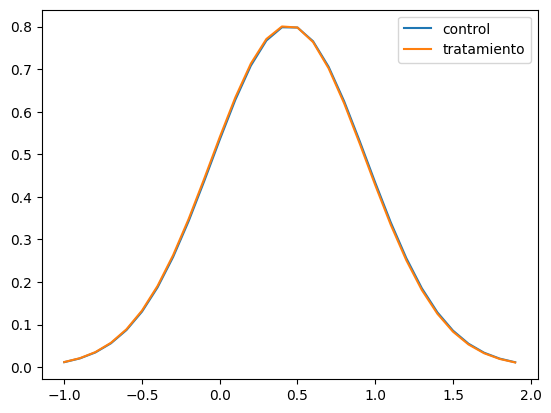

In [55]:

tasas_conversion = ab_test.groupby('version')['retention_1']    # agrupacion por grupo


std = lambda x: np.std(x, ddof=0)              # std
error_std= lambda x: stats.sem(x, ddof=0)      # sem = std/sqrt(n)

tasas_conversion = tasas_conversion.agg([np.mean, std, error_std])

tasas_conversion.columns = ['conversion_rate', 'std', 'sem']

tasas_conversion.style.format('{:.3f}')

x=[i*.1 for i in range(-10, 20)]  

# norm.pdf(x, media, std)

control=[norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']);

In [69]:
#testear retention_7
control_res=ab_test[ab_test.version=='gate_30']['retention_7']

trat_res=ab_test[ab_test.version=='gate_40']['retention_7']

conversiones=[control_res.sum(), trat_res.sum()]    # conversiones

impresiones=len(control_res),len(trat_res)

z_score, p_value = proportions_ztest(conversiones, nobs=impresiones)

(control_a, trata_a), (control_b, trata_b) = proportion_confint(conversiones, 
                                                                nobs=impresiones,
                                                                alpha=0.05)

In [70]:
print(f'z-score: {z_score:.2f}')

print(f'p-valor: {p_value:.3f}')

print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')

print(f'intervalo conf 95% para grupo tratamiento: [{trata_a:.3f}, {trata_b:.3f}]')

z-score: 3.16
p-valor: 0.002
intervalo conf 95% para grupo control: [0.187, 0.194]
intervalo conf 95% para grupo tratamiento: [0.178, 0.186]


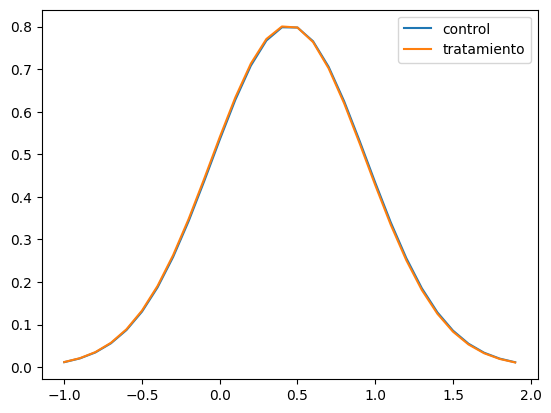

In [71]:
tasas_conversion = ab_test.groupby('version')['retention_1']    # agrupacion por grupo


std = lambda x: np.std(x, ddof=0)              # std
error_std= lambda x: stats.sem(x, ddof=0)      # sem = std/sqrt(n)

tasas_conversion = tasas_conversion.agg([np.mean, std, error_std])

tasas_conversion.columns = ['conversion_rate', 'std', 'sem']

tasas_conversion.style.format('{:.3f}')

x=[i*.1 for i in range(-10, 20)]  

# norm.pdf(x, media, std)

control=[norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']);